In [7]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time
import re

# --- Clean price helper ---
def clean_price(x):
    """Cleans price strings like 'Rs. 1,299' or '₹1,299' to float 1299.0"""
    if pd.isna(x):
        return None
    x = str(x)
    # Keep only digits (remove ₹, Rs., commas, dots used as thousand separators)
    num = re.sub(r'\D', '', x)
    return float(num) if num else None

# --- Setup Selenium WebDriver ---
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))

base_url = "https://www.myntra.com/women-dresses"
all_products = []
page = 1
products_seen = set()

while True:
    url = f"{base_url}?p={page}"
    driver.get(url)
    time.sleep(5)  # Let page load fully

    soup = BeautifulSoup(driver.page_source, "html.parser")
    product_cards = soup.find_all("li", class_="product-base")
    if not product_cards:
        break

    for card in product_cards:
        brand = card.find("h3", class_="product-brand")
        prod_name = card.find("h4", class_="product-product")
        brand = brand.text.strip() if brand else None
        prod_name = prod_name.text.strip() if prod_name else None

        link_tag = card.find("a")
        product_url = "https://www.myntra.com" + link_tag["href"] if link_tag and link_tag.has_attr("href") else None

        if product_url in products_seen:
            continue
        products_seen.add(product_url)

        # Price extraction
        mrp_tag = card.find("span", class_="product-strike")
        price_tag = card.find("span", class_="product-discountedPrice")
        alt_price_tag = card.find("span", class_="product-price")

        mrp_text = mrp_tag.text if mrp_tag else alt_price_tag.text if alt_price_tag else None
        price_text = price_tag.text if price_tag else alt_price_tag.text if alt_price_tag else None

        mrp = clean_price(mrp_text)
        price = clean_price(price_text)

        # Ratings and reviews
        rating_val, reviews = None, None
        rating_block = card.find("div", class_="product-ratingsContainer")
        if rating_block:
            spans = rating_block.find_all("span")
            if spans:
                rating_val = spans[0].text.strip() if len(spans) > 0 else None
                reviews = spans[-1].text.strip("()") if len(spans) > 1 else None

        all_products.append({
            "Product Name": prod_name,
            "Brand": brand,
            "Category": "Women Dresses",
            "MRP": mrp,
            "Discounted Price": price,
            "Rating": rating_val,
            "Number of Reviews": reviews,
            "Product URL": product_url
        })

    print(f"Page {page}: Collected {len(all_products)} products so far...")
    if len(all_products) >= 350:
        break
    page += 1

driver.quit()

# --- DataFrame ---
df = pd.DataFrame(all_products)

# Clean and prepare
df.drop_duplicates(subset=["Product URL"], inplace=True)
df["Brand"] = df["Brand"].str.strip().str.title()
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")
df["Number of Reviews"] = pd.to_numeric(df["Number of Reviews"], errors="coerce")

# Calculate discount %
df["Discount %"] = ((df["MRP"] - df["Discounted Price"]) / df["MRP"]) * 100
df["Discount %"] = pd.to_numeric(df["Discount %"], errors="coerce").round(2)

# Save cleaned data
df.to_csv("myntra_womens_dresses_clean.csv", index=False, encoding="utf-8-sig")
print(f"\n✅ Cleaned dataset: {df.shape[0]} products saved to myntra_womens_dresses_clean.csv")

# --- Sanity check ---
print("\n--- Sanity Check (first 5 rows) ---")
print(df[["MRP", "Discounted Price", "Discount %"]].head())

# --- Analysis summary ---
print("\n--- Descriptive Statistics ---")
print(df[["MRP", "Discounted Price", "Discount %", "Rating"]].describe())

print("\n--- Top 5 Brands by Number of Products ---")
print(df["Brand"].value_counts().head(5))

print("\n--- Average Discount % by Brand (Top 5) ---")
print(df.groupby("Brand")["Discount %"].mean().sort_values(ascending=False).head(5))

avg_price = df["Discounted Price"].mean()
avg_rating = df["Rating"].mean()
corr = df[["Rating", "Discount %"]].dropna().corr().iloc[0,1]

print("\n--- Category Insights (Women Dresses) ---")
print(f"Average discounted price: ₹{avg_price:.2f}")
print(f"Average rating: {avg_rating:.2f}")
print(f"Correlation between Ratings and Discount %: {corr:.2f}")

df.to_csv("myntra_womens_dresses_analysis_ready.csv", index=False, encoding="utf-8-sig")
print("\n✅ Analysis complete. Data saved to myntra_womens_dresses_analysis_ready.csv")


Page 1: Collected 50 products so far...
Page 2: Collected 94 products so far...
Page 3: Collected 138 products so far...
Page 4: Collected 184 products so far...
Page 5: Collected 218 products so far...
Page 6: Collected 252 products so far...
Page 7: Collected 286 products so far...
Page 8: Collected 320 products so far...
Page 9: Collected 354 products so far...

✅ Cleaned dataset: 354 products saved to myntra_womens_dresses_clean.csv

--- Sanity Check (first 5 rows) ---
      MRP  Discounted Price  Discount %
0  2899.0             985.0       66.02
1  3999.0             759.0       81.02
2  5790.0            3474.0       40.00
3  2899.0             739.0       74.51
4  2577.0             773.0       70.00

--- Descriptive Statistics ---
               MRP  Discounted Price  Discount %      Rating
count   342.000000        342.000000  342.000000  337.000000
mean   2964.824561       1090.383041   62.517193    4.069733
std    1092.629564        647.583835   13.681639    0.408581
min   

Shape: (354, 9)
                          Product Name          Brand       Category     MRP  \
0        Women  Fit & Flare Midi Dress         Claura  Women Dresses  2899.0   
1            Printed A-Line Midi Dress           Pimu  Women Dresses  3999.0   
2                    A-Line Midi Dress          Mango  Women Dresses  5790.0   
3  Floral Print Fit & Flare Maxi Dress         Stylum  Women Dresses  2899.0   
4          Floral Printed Empire Dress  House Of Mira  Women Dresses  2577.0   

   Discounted Price  Rating  Number of Reviews  \
0             985.0     4.3                NaN   
1             759.0     2.8                NaN   
2            3474.0     3.6                NaN   
3             739.0     4.2                NaN   
4             773.0     3.8                NaN   

                                         Product URL  Discount %  
0  https://www.myntra.comdresses/claura/claura-wo...       66.02  
1  https://www.myntra.comdresses/pimu/pimu-women-...       81.02  
2

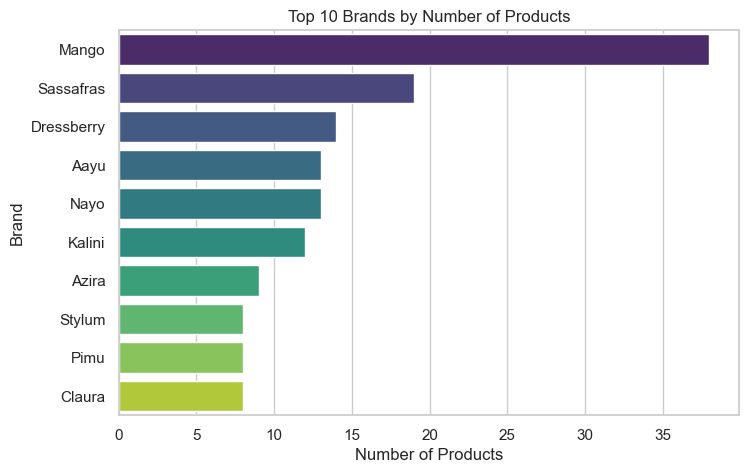

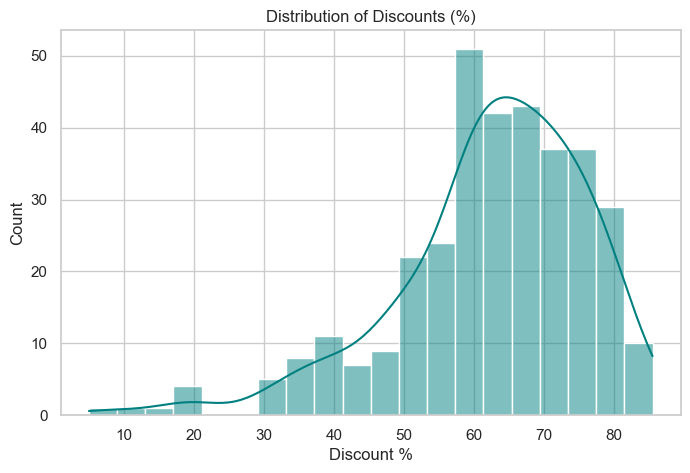

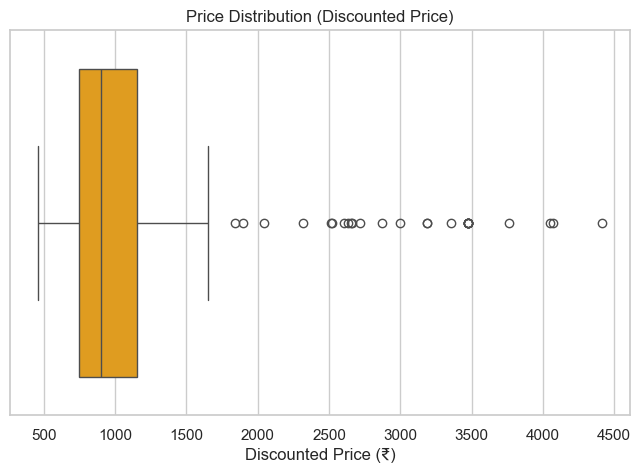

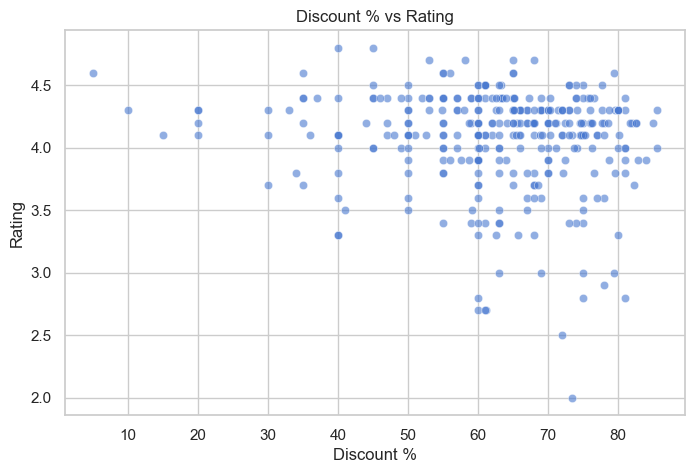

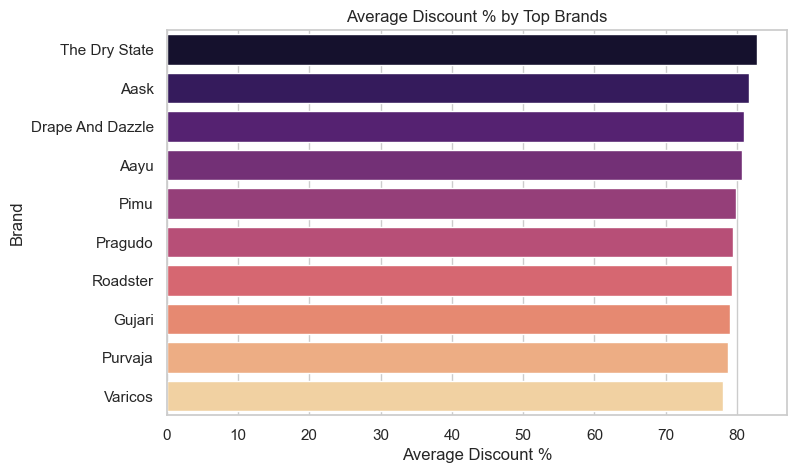

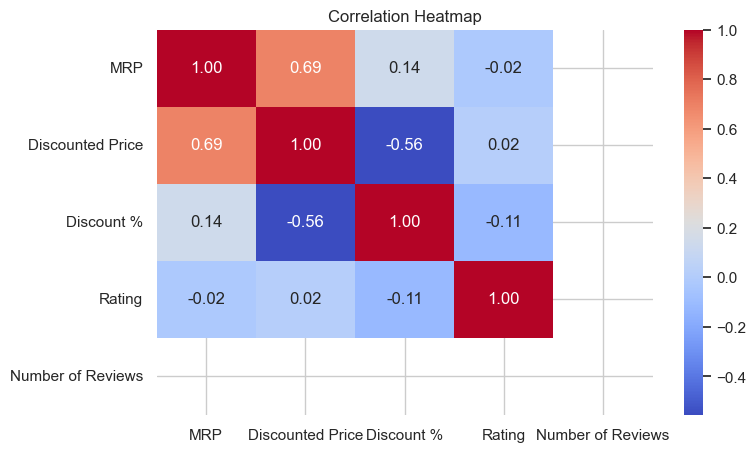

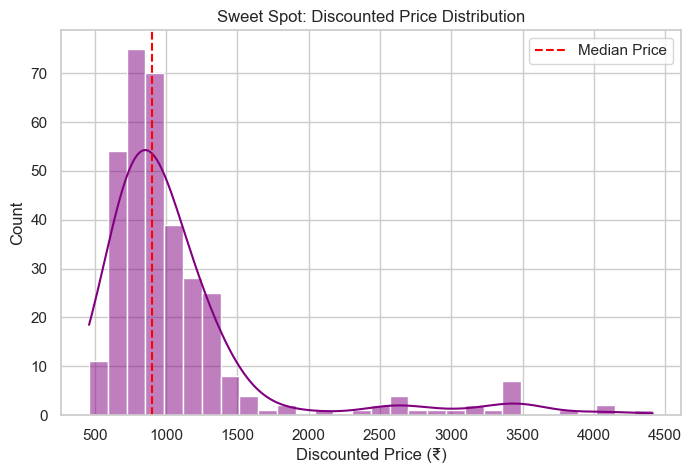


✅ EDA Complete: All plots generated.


In [9]:
# Myntra Women's Dresses EDA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load Data
df = pd.read_csv("myntra_womens_dresses_analysis_ready.csv")

print("Shape:", df.shape)
print(df.head())

Basic Stats
print("\n--- Descriptive Statistics ---")
print(df[["MRP", "Discounted Price", "Discount %", "Rating"]].describe())

#Plot Styles
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8, 5)

#1. Top 10 Brands by Number of Products
top_brands = df["Brand"].value_counts().head(10)
sns.barplot(x=top_brands.values, y=top_brands.index, hue=top_brands.index, palette="viridis", legend=False)
plt.title("Top 10 Brands by Number of Products")
plt.xlabel("Number of Products")
plt.ylabel("Brand")
plt.show()

#2. Distribution of Discounts
sns.histplot(df["Discount %"], bins=20, kde=True, color="teal")
plt.title("Distribution of Discounts (%)")
plt.xlabel("Discount %")
plt.ylabel("Count")
plt.show()

#3. Price Distribution
sns.boxplot(x=df["Discounted Price"], color="orange")
plt.title("Price Distribution (Discounted Price)")
plt.xlabel("Discounted Price (₹)")
plt.show()

#4. Average Rating vs Discount % 
sns.scatterplot(x="Discount %", y="Rating", data=df, alpha=0.6)
plt.title("Discount % vs Rating")
plt.xlabel("Discount %")
plt.ylabel("Rating")
plt.show()

#5. Average Discount % by Top Brands
avg_discount = df.groupby("Brand")["Discount %"].mean().sort_values(ascending=False).head(10)
sns.barplot(x=avg_discount.values, y=avg_discount.index, hue=avg_discount.index, palette="magma", legend=False)
plt.title("Average Discount % by Top Brands")
plt.xlabel("Average Discount %")
plt.ylabel("Brand")
plt.show()

#6. Correlation Heatmap
corr = df[["MRP", "Discounted Price", "Discount %", "Rating", "Number of Reviews"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#7. Sweet Spot Price Range
sns.histplot(df["Discounted Price"], bins=30, kde=True, color="purple")
plt.axvline(df["Discounted Price"].median(), color="red", linestyle="--", label="Median Price")
plt.title("Sweet Spot: Discounted Price Distribution")
plt.xlabel("Discounted Price (₹)")
plt.ylabel("Count")
plt.legend()
plt.show()

print("\n✅ EDA Complete: All plots generated.")


In [10]:
# =========================================
# Advanced EDA + Business Insights (PNG out)
# =========================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------- Config ---------
INPUT_CSV = "myntra_womens_dresses_analysis_ready.csv"
FIG_DIR = "figures"
os.makedirs(FIG_DIR, exist_ok=True)

# --------- Load ---------
df = pd.read_csv(INPUT_CSV)

# Basic cleaning just-in-case
numeric_cols = ["MRP", "Discounted Price", "Discount %", "Rating", "Number of Reviews"]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# --------- Descriptives ---------
desc = df[["MRP","Discounted Price","Discount %","Rating","Number of Reviews"]].describe()
print(desc)

# --------- Helper: safe save ---------
def savefig(path):
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, path), dpi=200, bbox_inches="tight")
    plt.close()

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

# 1) Histogram – Distribution of Discounted Price
plt.figure()
sns.histplot(df["Discounted Price"].dropna(), bins=30, kde=True)
plt.title("Distribution of Discounted Price (₹)")
plt.xlabel("Discounted Price (₹)")
plt.ylabel("Count")
savefig("hist_discounted_price.png")

# 2) Bar chart – Average Discount % by Brand (Top 15 by product count)
brand_counts = df["Brand"].value_counts()
top_brands = brand_counts.head(15).index
avg_discount_top = (
    df[df["Brand"].isin(top_brands)]
    .groupby("Brand")["Discount %"]
    .mean()
    .sort_values(ascending=False)
)
plt.figure()
sns.barplot(x=avg_discount_top.values, y=avg_discount_top.index)
plt.title("Average Discount % by Brand (Top 15 by volume)")
plt.xlabel("Average Discount %")
plt.ylabel("Brand")
savefig("bar_avg_discount_by_brand.png")

# 3) Box plot – Price distribution
plt.figure()
sns.boxplot(x=df["Discounted Price"].dropna())
plt.title("Box Plot – Discounted Price Distribution")
plt.xlabel("Discounted Price (₹)")
savefig("box_discounted_price.png")

# 4) Scatter – Ratings vs Discount %
plt.figure()
sns.scatterplot(data=df, x="Discount %", y="Rating", alpha=0.6)
plt.title("Ratings vs Discount %")
plt.xlabel("Discount %")
plt.ylabel("Rating")
savefig("scatter_rating_vs_discount.png")

# 5) Correlation Heatmap
plt.figure(figsize=(7,6))
corr = df[["MRP","Discounted Price","Discount %","Rating","Number of Reviews"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap")
savefig("heatmap_correlation.png")

# 6) Price band analysis – define market bands for quick business read
bins = [0, 799, 999, 1299, 1599, 1999, 2499, 2999, 4999, np.inf]
labels = ["≤799","800–999","1000–1299","1300–1599","1600–1999",
          "2000–2499","2500–2999","3000–4999","≥5000"]
df["Price Band"] = pd.cut(df["Discounted Price"], bins=bins, labels=labels, right=True)

band_counts = df["Price Band"].value_counts().reindex(labels)
plt.figure()
sns.barplot(x=band_counts.index, y=band_counts.values)
plt.title("Product Count by Discounted Price Band")
plt.xlabel("Price Band (₹)")
plt.ylabel("Count")
plt.xticks(rotation=30)
savefig("bar_count_by_price_band.png")

# 7) Premium vs mass-market sketch – avg price & avg discount by brand (Top 20 by volume)
top20 = df["Brand"].value_counts().head(20).index
brand_profile = (
    df[df["Brand"].isin(top20)]
    .groupby("Brand")
    .agg(avg_price=("Discounted Price","mean"),
         avg_discount=("Discount %","mean"),
         n=("Brand","size"))
    .sort_values("avg_price", ascending=False)
)
print("\nBrand price/discount profile (Top 20 by volume):\n", brand_profile.round(2).head(20))

plt.figure()
sns.scatterplot(data=brand_profile, x="avg_discount", y="avg_price", size="n", sizes=(50, 300))
for b, row in brand_profile.iterrows():
    plt.text(row["avg_discount"]+0.3, row["avg_price"]+10, b, fontsize=8)
plt.title("Brand Positioning: Avg Discount vs Avg Price (bubble=size)")
plt.xlabel("Avg Discount %")
plt.ylabel("Avg Discounted Price (₹)")
savefig("scatter_brand_positioning.png")

# 8) Reviews as sales proxy – relationship with price/discount
plt.figure()
sns.scatterplot(data=df, x="Discounted Price", y="Number of Reviews", alpha=0.5)
plt.title("Reviews vs Discounted Price (proxy for demand)")
plt.xlabel("Discounted Price (₹)")
plt.ylabel("Number of Reviews")
savefig("scatter_reviews_vs_price.png")

plt.figure()
sns.scatterplot(data=df, x="Discount %", y="Number of Reviews", alpha=0.5)
plt.title("Reviews vs Discount % (proxy for demand)")
plt.xlabel("Discount %")
plt.ylabel("Number of Reviews")
savefig("scatter_reviews_vs_discount.png")

# --------- Textual insights (prints) ---------
print("\n— Business Readouts —")
print(f"Avg discounted price: ₹{df['Discounted Price'].mean():.2f}")
print(f"Median discounted price: ₹{df['Discounted Price'].median():.2f}")
print(f"Avg discount %: {df['Discount %'].mean():.2f}%")
print("Top 10 brands by volume:\n", df['Brand'].value_counts().head(10))

# Premium brands (higher avg price, lower avg discount) vs Value brands (lower price, higher discount)
premium_cut = df["Discounted Price"].quantile(0.75)
value_cut = df["Discounted Price"].quantile(0.25)
brand_pos = (
    df.groupby("Brand")
      .agg(avg_price=("Discounted Price","mean"),
           avg_discount=("Discount %","mean"),
           n=("Brand","size"))
      .query("n >= 5")  # avoid tiny samples
)
premium_candidates = brand_pos.query("avg_price >= @premium_cut and avg_discount <= @brand_pos['avg_discount'].median()")
value_candidates   = brand_pos.query("avg_price <= @value_cut and avg_discount >= @brand_pos['avg_discount'].median()")

print("\nPremium-leaning brands (high price, below-median discount):")
print(premium_candidates.sort_values(["avg_price","avg_discount"], ascending=[False, True]).round(2).head(10))

print("\nValue-leaning brands (low price, above-median discount):")
print(value_candidates.sort_values(["avg_discount","avg_price"], ascending=[False, True]).round(2).head(10))

print("\n✅ Advanced EDA complete. Figures saved in ./figures")


               MRP  Discounted Price  Discount %      Rating  \
count   342.000000        342.000000  342.000000  337.000000   
mean   2964.824561       1090.383041   62.517193    4.069733   
std    1092.629564        647.583835   13.681639    0.408581   
min     799.000000        460.000000    5.000000    2.000000   
25%    2099.250000        749.500000   55.955000    3.900000   
50%    2699.000000        899.000000   64.995000    4.200000   
75%    3499.000000       1153.500000   72.342500    4.300000   
max    6790.000000       4413.000000   85.520000    4.800000   

       Number of Reviews  
count                0.0  
mean                 NaN  
std                  NaN  
min                  NaN  
25%                  NaN  
50%                  NaN  
75%                  NaN  
max                  NaN  

Brand price/discount profile (Top 20 by volume):
                    avg_price  avg_discount   n
Brand                                         
Mango                2808.33       